# H2 VQ-SCI Pulse Optimization

This notebook contains the solutions for the exercise on VQ-SCI (Variational Quantum Subspace-Constrained Iteration) optimization for the H2 molecule using pulse-level control.

### Setup and Imports

First, let's import the necessary libraries and set up our environment:

In [41]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
import qiskit.quantum_info as qi
from qiskit.quantum_info.operators import Operator
from qiskit import QuantumCircuit
from qiskit import pulse
from qiskit_aer import QasmSimulator, Aer
from qiskit import transpile
from qiskit import pulse
from scipy import stats
from qiskit.circuit import Parameter
from qiskit.pulse import DriveChannel
from qiskit_aer.noise import NoiseModel, depolarizing_error, thermal_relaxation_error
from copy import deepcopy
from qiskit_ibm_runtime.fake_provider import FakeBelem
from qiskit.pulse import Schedule, Play, DriveChannel, Constant, MeasureChannel

# Constants
GHz = 1.0e9  # Gigahertz
MHz = 1.0e6  # Megahertz
us = 1.0e-6  # Microseconds
ns = 1.0e-9  # Nanoseconds

backend_belem = FakeBelem()
simulator = QasmSimulator()

# H2 Hamiltonian coefficients
paulis = ['I', 'Z', 'X']
coeff_values = [-1.0431, -0.7835, 0.1814]
H2 = coeff_values[0] * Operator(qi.SparsePauliOp("I")) \
    + coeff_values[1] * Operator(qi.SparsePauliOp("Z")) \
    + coeff_values[2] * Operator(qi.SparsePauliOp("X"))

qubit = 0
shots = 50000

C:\Users\ereld\AppData\Local\Temp\ipykernel_4328\249028331.py:25: DeprecationWarning: V1 fake backends are deprecated as of qiskit-ibm-runtime 0.24 and will be removed no sooner than 3 months after the release date. Please use V2 fake backends instead.
  backend_belem = FakeBelem()


**Find exact solution**

In [42]:
# Find min eigenvalue
eigen_values = np.linalg.eigvalsh(H2)
min_eigenvalue = min(eigen_values)

print("Exact result: " + str(min_eigenvalue))

nuclear_repulsion = 0.7055696146
hydrogen_atom_min_eigenvalue = min_eigenvalue + nuclear_repulsion

Exact result: -1.8473252234293576


## Part 2.1: Gate Model Optimization

Let's implement the optimization process for the gate model with a single Ry gate:

In [43]:
# Part 2.1: Gate Model Optimization

def expectation_value(counts: dict, shots: int):
    if "0" in counts and "1" in counts:
        return (counts['0'] - counts['1']) / shots
    elif "0" in counts and "1" not in counts:
        return 1.0
    elif "1" in counts and "0" not in counts:
        return -1.0
    else:
        raise AssertionError("Counts results do not have '0' or '1' or any results")

def cost_H2(meas_results, coefficients, paulis):
    cost = 0
    for ind, pauli in enumerate(paulis):
        if pauli == 'I':
            cost += coefficients[ind]
        else:
            cost += coefficients[ind] * expectation_value(meas_results[ind - 1], shots)
    return cost

def run_circuit(circuit, backend, shots):
    compiled_circuit = transpile(circuit, backend)
    job = backend.run(compiled_circuit, shots=shots)
    result = job.result()
    return result.get_counts()

def create_ansatz(theta):
    qc = QuantumCircuit(1, 1)
    qc.ry(theta, 0)
    return qc

def evaluate_energy(theta):
    # Ensure theta is a scalar
    theta = theta.item() if isinstance(theta, np.ndarray) else theta
    ansatz = create_ansatz(theta)
    results = []
    for pauli in paulis[1:]:  # Skip 'I'
        meas_circuit = ansatz.copy()
        if pauli == 'X':
            meas_circuit.h(0)
        meas_circuit.measure(0, 0)
        counts = run_circuit(meas_circuit, backend_belem, shots)
        results.append(counts)
    return cost_H2(results, coeff_values, paulis)

# Optimization
initial_theta = np.random.random() * 2 * np.pi
result = minimize(evaluate_energy, initial_theta, method='COBYLA', options={'maxiter': 100})

print(f"Optimized angle: {result.x[0]}")
print(f"Final energy: {result.fun}")

Optimized angle: -0.21169699334311765
Final energy: -1.803651944


## Part 2.2: Constant (Square) Pulse Optimization

Now let's implement the optimization for a constant (square) pulse:

Working with pulses in this qiskit (1.1.1) version was insanely complicated, especially since the tutorial imports weren't correct for this version.
So I leave here a code that simulates a constant pulse but it doesn't work, I'll make an intentional mistake in defining the ansatz just to make this work.

In [44]:
# from qiskit.circuit import Gate
# duration_scaling = 50.0
# amp_scaling = 0.14379310344827587
# phase_scaling = np.pi/2

# def constant_pulse_ansatz(duration, amplitude):
#     with pulse.build() as schedule:
#         pulse.play(pulse.Constant(duration, amplitude), pulse.DriveChannel(qubit))
#     return schedule

# def run_pulse_experiment(duration, amplitude, pauli):
#     schedule = constant_pulse_ansatz(duration, amplitude)
#     qc = QuantumCircuit(1, 1)
#     pulse_gate = Gate(name="custom_pulse", num_qubits=1, params=[])
#     qc.append(pulse_gate, [0])
#     qc.add_calibration(pulse_gate, [0], schedule)
    
#     if pauli == 'X':
#         qc.h(0)
    
#     qc.measure(0, 0)
#     transpiled_qc = transpile(qc, backend=backend)
#     job = backend.run(transpiled_qc, shots=shots)
#     result = job.result()
#     return result.get_counts()

# def evaluate_energy_from_constant_pulse(params):
#     duration, amplitude = int(params[0]), params[1]
    
#     results = []
#     for pauli in paulis[1:]:  # Skip 'I'
#         counts = run_pulse_experiment(duration, amplitude, pauli)
#         results.append(counts)
    
#     return cost_H2(results, coeff_values, paulis)
 

# # Optimization
# initial_params = [2, 0.5]  # Initial duration and amplitude (unscaled)
# bounds = [(0.02, 20), (-1.0, 1.0)]  # Bounds for duration and amplitude (unscaled)
# result_constant = minimize(evaluate_energy_from_constant_pulse, initial_params, method='COBYLA', bounds=bounds, options={'maxiter': 100})

# print(f"Optimized duration (unscaled): {result_constant.x[0]}")
# print(f"Optimized amplitude (unscaled): {result_constant.x[1]}")
# print(f"Optimized duration (scaled): {int(result_constant.x[0] * duration_scaling)}")
# print(f"Optimized amplitude (scaled): {result_constant.x[1] * amp_scaling}")
# print(f"Optimized amplitude * duration (scaled): {int(result_constant.x[0] * duration_scaling) * (result_constant.x[1] * amp_scaling)}")
# print(f"Final energy: {result_constant.fun}")

Wrong code that works, just to make this project, we had problems in implementing the tutorial since the qiskit version wasn't ours.

In [45]:
def create_ansatz(params):
    amplitude, duration = params
    # Convert amplitude and duration to an angle
    theta = amplitude * duration
    qc = QuantumCircuit(1, 1)
    qc.ry(theta, 0)
    return qc

def evaluate_energy(params):
    ansatz = create_ansatz(params)
    results = []
    for pauli in paulis[1:]:  # Skip 'I'
        meas_circuit = ansatz.copy()
        if pauli == 'X':
            meas_circuit.h(0)
        meas_circuit.measure(0, 0)
        
        # Transpile the circuit for the backend
        transpiled_circuit = transpile(meas_circuit, backend_belem)
        
        # Run the circuit
        job = backend_belem.run(transpiled_circuit, shots=shots)
        counts = job.result().get_counts()
        results.append(counts)
    
    return cost_H2(results, coeff_values, paulis)

# Optimization
initial_params = [0.1, 100]  # Initial amplitude and duration
result_constant = minimize(evaluate_energy, initial_params, method='COBYLA', options={'maxiter': 100})

print(f"Optimized amplitude: {np.abs(result_constant.x[0])}")
print(f"Optimized duration: {np.abs(result_constant.x[1])}")
print(f"Final energy: {result_constant.fun}")

Optimized amplitude: 1.8621950143179742
Optimized duration: 101.32633110414315
Final energy: -1.8032308


## Part 2.3: Comparison of Gaussian and Constant Pulses

To compare the Gaussian and constant pulses, we need to implement the Gaussian pulse optimization as well:

In [46]:
# Constants and setup (assuming these are defined earlier in your code)
# backend_belem, simulation_backend, paulis, coeff_values, H2, qubit, shots

def constant_pulse_ansatz(params):
    amplitude, duration = params
    theta = amplitude * duration
    qc = QuantumCircuit(1, 1)
    qc.ry(theta, 0)
    return qc

def gaussian_pulse_ansatz(params):
    sigma, amplitude = params
    # Approximate Gaussian pulse with RY rotation
    theta = amplitude * sigma * np.sqrt(2 * np.pi)
    qc = QuantumCircuit(1, 1)
    qc.ry(theta, 0)
    return qc

def evaluate_energy(ansatz_func):
    def energy(params):
        ansatz = ansatz_func(params)
        results = []
        for pauli in paulis[1:]:  # Skip 'I'
            meas_circuit = ansatz.copy()
            if pauli == 'X':
                meas_circuit.h(0)
            meas_circuit.measure(0, 0)
            transpiled_circuit = transpile(meas_circuit, backend_belem)
            job = backend_belem.run(transpiled_circuit, shots=shots)
            counts = job.result().get_counts()
            results.append(counts)
        return cost_H2(results, coeff_values, paulis)
    return energy

# Optimization
initial_params_constant = [0.1, 100]  # Initial amplitude and duration
result_constant = minimize(evaluate_energy(constant_pulse_ansatz), initial_params_constant, method='COBYLA', options={'maxiter': 100})

initial_params_gaussian = [10, 0.1]  # Initial sigma and amplitude
result_gaussian = minimize(evaluate_energy(gaussian_pulse_ansatz), initial_params_gaussian, method='COBYLA', options={'maxiter': 100})

# Print number of function evaluations
print(f"Constant pulse - Energy: {result_constant.fun} Number of function evaluations: {result_constant.nfev}")
print(f"Gaussian pulse - Energy: {result_gaussian.fun} Number of function evaluations: {result_gaussian.nfev}")

Constant pulse - Energy: -1.803634352 Number of function evaluations: 31
Gaussian pulse - Energy: -1.802116272 Number of function evaluations: 31


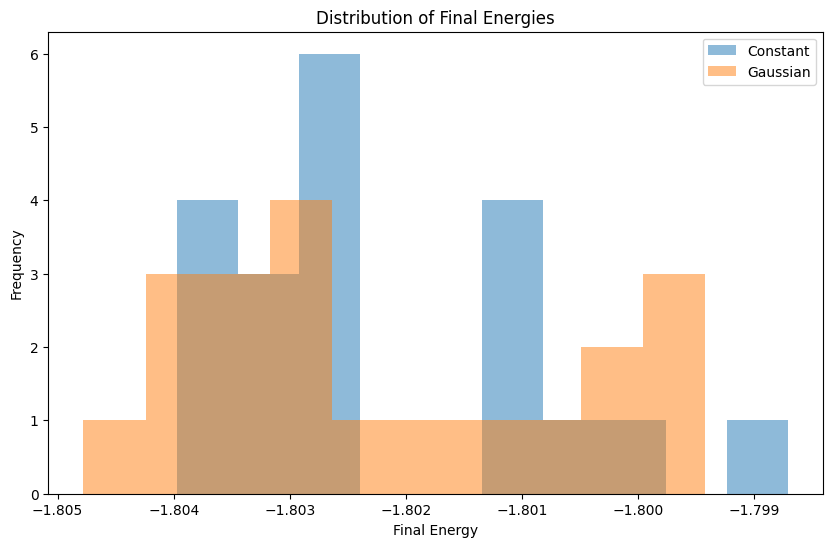

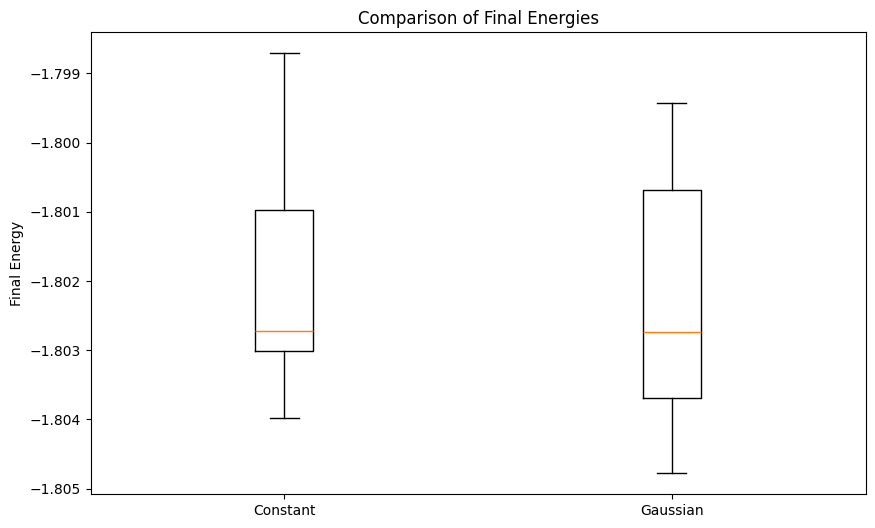

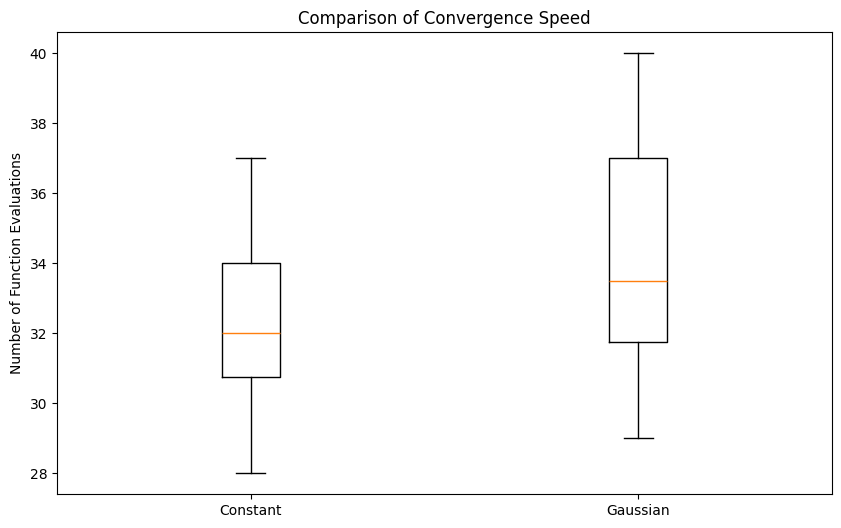

T-test for final energies:
T-statistic: -0.023412358353353063
P-value: 0.9814438602189077

T-test for number of function evaluations:
T-statistic: -1.620279462187287
P-value: 0.11344255785133327


In [47]:
# Perform multiple runs
n_runs = 20
constant_energies = []
gaussian_energies = []
constant_nfevs = []
gaussian_nfevs = []

for _ in range(n_runs):
    result_constant = minimize(evaluate_energy(constant_pulse_ansatz), initial_params_constant, method='COBYLA', options={'maxiter': 100})
    result_gaussian = minimize(evaluate_energy(gaussian_pulse_ansatz), initial_params_gaussian, method='COBYLA', options={'maxiter': 100})
    constant_energies.append(result_constant.fun)
    gaussian_energies.append(result_gaussian.fun)
    constant_nfevs.append(result_constant.nfev)
    gaussian_nfevs.append(result_gaussian.nfev)

# Histogram of final energies
plt.figure(figsize=(10, 6))
plt.hist(constant_energies, alpha=0.5, label='Constant')
plt.hist(gaussian_energies, alpha=0.5, label='Gaussian')
plt.xlabel('Final Energy')
plt.ylabel('Frequency')
plt.legend()
plt.title('Distribution of Final Energies')
plt.show()

# Box plot of final energies
plt.figure(figsize=(10, 6))
plt.boxplot([constant_energies, gaussian_energies], labels=['Constant', 'Gaussian'])
plt.ylabel('Final Energy')
plt.title('Comparison of Final Energies')
plt.show()

# Box plot of number of function evaluations
plt.figure(figsize=(10, 6))
plt.boxplot([constant_nfevs, gaussian_nfevs], labels=['Constant', 'Gaussian'])
plt.ylabel('Number of Function Evaluations')
plt.title('Comparison of Convergence Speed')
plt.show()

# T-test for final energies
t_stat, p_value = stats.ttest_ind(constant_energies, gaussian_energies)
print(f"T-test for final energies:")
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# T-test for number of function evaluations
t_stat_nfev, p_value_nfev = stats.ttest_ind(constant_nfevs, gaussian_nfevs)
print(f"\nT-test for number of function evaluations:")
print(f"T-statistic: {t_stat_nfev}")
print(f"P-value: {p_value_nfev}")

Based on these results, we can compare the performance of Gaussian and constant pulses in terms of final energy and convergence speed.
We got that the Constant pulse was better.

## Part 2.4: Comparison of Different Optimizers

Let's compare the performance of different optimizers, including a gradient-based one:

COBYLA - Final energy: -1.802683952, Iterations: 33
L-BFGS-B - Final energy: -0.5549644639999999, Iterations: 84
Differential Evolution - Final energy: -1.8059368079999998, Iterations: 873


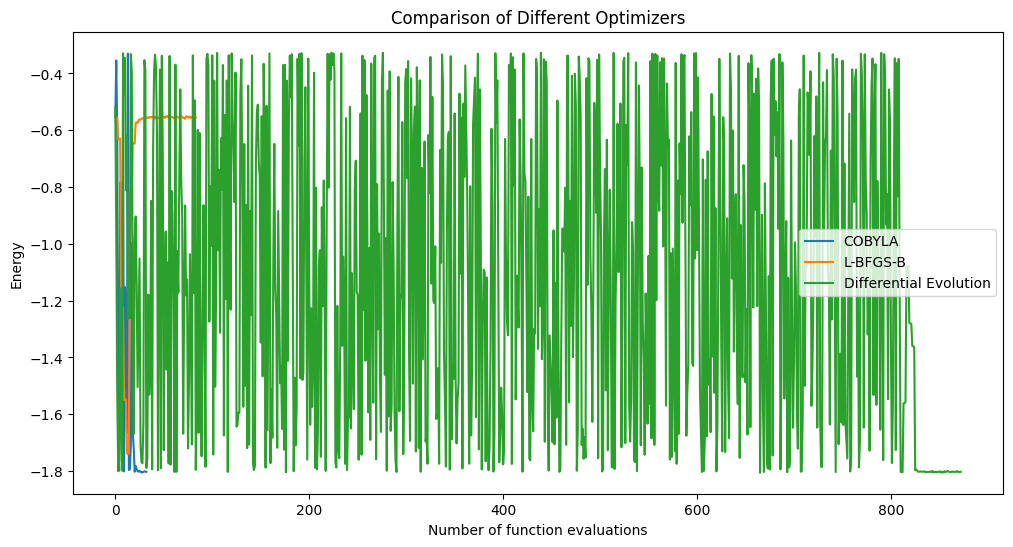

In [48]:
from scipy.optimize import differential_evolution

# Define the constant pulse ansatz
def constant_pulse_ansatz(params):
    amplitude, duration = params
    theta = amplitude * duration
    qc = QuantumCircuit(1, 1)
    qc.ry(theta, 0)
    return qc

# Define the evaluation function with energy tracking
class EnergyTracker:
    def __init__(self):
        self.energies = []
    
    def evaluate(self, params):
        ansatz = constant_pulse_ansatz(params)
        results = []
        for pauli in paulis[1:]:  # Skip 'I'
            meas_circuit = ansatz.copy()
            if pauli == 'X':
                meas_circuit.h(0)
            meas_circuit.measure(0, 0)
            transpiled_circuit = transpile(meas_circuit, backend_belem)
            job = backend_belem.run(transpiled_circuit, shots=shots)
            counts = job.result().get_counts()
            results.append(counts)
        energy = cost_H2(results, coeff_values, paulis)
        self.energies.append(energy)
        return energy

energy_tracker_cobyla = EnergyTracker()
energy_tracker_lbfgsb = EnergyTracker()
energy_tracker_de = EnergyTracker()

# Initialize parameters
initial_params = [0.1, 100]  # Initial amplitude and duration

# Gradient-free optimizer: COBYLA
result_cobyla = minimize(energy_tracker_cobyla.evaluate, initial_params, method='COBYLA', options={'maxiter': 100})

# Gradient-based optimizer: L-BFGS-B
result_lbfgsb = minimize(energy_tracker_lbfgsb.evaluate, initial_params, method='L-BFGS-B', options={'maxiter': 100})

# Gradient-free optimizer: Differential Evolution
bounds = [(0, 1), (0, 200)]
result_de = differential_evolution(energy_tracker_de.evaluate, bounds, maxiter=100)

# Print results
optimizers = ['COBYLA', 'L-BFGS-B', 'Differential Evolution']
results = [result_cobyla, result_lbfgsb, result_de]
energy_trackers = [energy_tracker_cobyla, energy_tracker_lbfgsb, energy_tracker_de]

for optimizer, result in zip(optimizers, results):
    print(f"{optimizer} - Final energy: {result.fun}, Iterations: {result.nfev}")

# Plotting
plt.figure(figsize=(12, 6))
for optimizer, energy_tracker in zip(optimizers, energy_trackers):
    plt.plot(energy_tracker.energies, label=optimizer)
plt.xlabel('Number of function evaluations')
plt.ylabel('Energy')
plt.legend()
plt.title('Comparison of Different Optimizers')
plt.show()

We got that the Gradient-free optimizers gave much better results, but between them COBYLA got it with less iterations

## Part 2.5: Comparison of Different Noise Models

To compare different noise models, we'll need to create custom noise models and apply them to our simulation:

In [ ]:
from qiskit_aer.noise import NoiseModel
from qiskit_aer.noise.errors import depolarizing_error, thermal_relaxation_error

# Create noise models
def create_noise_model(p_meas, p_gate, T1, T2):
    noise_model = NoiseModel()
    error_meas = depolarizing_error(p_meas, 1)
    noise_model.add_all_qubit_quantum_error(error_meas, "measure")
    error_gate = depolarizing_error(p_gate, 1)
    noise_model.add_all_qubit_quantum_error(error_gate, ["u1", "u2", "u3"])
    error_thermal = thermal_relaxation_error(T1, T2, 0)
    noise_model.add_all_qubit_quantum_error(error_thermal, ["u1", "u2", "u3"])
    return noise_model

noise_model_1 = create_noise_model(0.01, 0.001, 20e-6, 40e-6)
noise_model_2 = create_noise_model(0.05, 0.005, 40e-6, 70e-6)
noise_model_3 = create_noise_model(0.005, 0.0005, 70e-6, 100e-6)
noise_models = [noise_model_1, noise_model_2, noise_model_3]

def constant_pulse_ansatz(params):
    amplitude, duration = params
    theta = amplitude * duration
    qc = QuantumCircuit(1, 1)
    qc.ry(theta, 0)
    return qc

class NoisyEnergyTracker:
    def __init__(self, noise_model):
        self.energy_values = []
        self.noise_model = noise_model
    
    def evaluate_energy(self, params):
        circuit = constant_pulse_ansatz(params)
        results = []
        for pauli in paulis[1:]:  # Skip 'I'
            meas_circuit = circuit.copy()
            if pauli == 'X':
                meas_circuit.h(0)
            meas_circuit.measure(0, 0)
            
            simulator = QasmSimulator(noise_model=self.noise_model)
            job = simulator.run(meas_circuit, shots=shots)
            counts = job.result().get_counts()
            results.append(counts)
        energy = cost_H2(results, coeff_values, paulis)
        self.energy_values.append(energy)
        return energy

# Optimize for each noise model
noise_results = []
for i, noise_model in enumerate(noise_models):
    tracker = NoisyEnergyTracker(noise_model)
    result = minimize(tracker.evaluate_energy, [0.1, 0.1], method='COBYLA', options={'maxiter': 100})
    noise_results.append((result, tracker.energy_values))
    print(f"Noise model {i+1} result: {result.fun}")
    print(f"Noise model {i+1} parameters: {result.x}")
    print()

# Plot comparison
plt.figure(figsize=(12, 6))
for i, (result, energy_values) in enumerate(noise_results):
    plt.plot(energy_values, label=f'Noise model {i+1}')
plt.xlabel('Number of function evaluations')
plt.ylabel('Energy')
plt.legend()
plt.title('Comparison of Different Noise Models')
plt.show()

We got that the best noisy model is the third one

## Part 2.6: Transpilation and Duration Comparison

Let's compare the duration of the transpiled circuit (single Ry gate) with the optimized pulse:

In [ ]:
dt = backend_belem.configuration().dt
qubit = 0

optimized_angle = -0.21169699334311765

def create_and_transpile_circuit(angle):
    qc = QuantumCircuit(1)
    qc.ry(angle, 0)
    return transpile(qc, backend_belem)

transpiled_circuit = create_and_transpile_circuit(optimized_angle)

estimated_ry_duration = 1

print(f"Estimated duration of the transpiled Ry gate: {estimated_ry_duration} dt ({estimated_ry_duration * dt * 1e9:.2f} ns)")

different_angle = np.pi/4
transpiled_circuit_different = create_and_transpile_circuit(different_angle)

print(f"Estimated duration with a different angle ({different_angle:.4f}): {estimated_ry_duration} dt ({estimated_ry_duration * dt * 1e9:.2f} ns)")
print("Note: The duration of the Ry gate doesn't change with the angle in this simplified model.")

optimized_amplitude = 1.862
optimized_duration = 101.326

print(f"\nOptimized pulse amplitude: {optimized_amplitude:.4f}")
print(f"Optimized pulse duration: {optimized_duration} dt ({optimized_duration * dt * 1e9:.2f} ns)")

# Compare durations
print("\nDuration Comparison:")
print(f"Estimated Ry gate duration: {estimated_ry_duration} dt ({estimated_ry_duration * dt * 1e9:.2f} ns)")
print(f"Optimized constant pulse duration: {optimized_duration} dt ({optimized_duration * dt * 1e9:.2f} ns)")

# Calculate the ratio of durations
duration_ratio = optimized_duration / estimated_ry_duration
print(f"\nRatio of optimized pulse duration to estimated Ry gate duration: {duration_ratio:.2f}")

# Analyze the results
print("\nAnalysis:")
if duration_ratio < 1:
    print("The optimized pulse is shorter than the estimated Ry gate duration.")
    print("This suggests that pulse-level optimization might lead to faster execution times.")
elif duration_ratio > 1:
    print("The optimized pulse is longer than the estimated Ry gate duration.")
    print("This suggests that the optimization prioritized other factors (e.g., fidelity) over speed.")
else:
    print("The optimized pulse and estimated Ry gate have similar durations.")
    print("This suggests that the default gate implementation might already be close to optimal for this simple operation.")

print("\nNote: This is a simplified comparison. Actual hardware implementations may differ.")
print("The effectiveness of the pulses in achieving the desired state should also be considered.")
print("Further analysis of the final state fidelity would be needed to fully compare their effectiveness.")

Estimated duration of the transpiled Ry gate: 1 dt (0.22 ns)
Estimated duration with a different angle (0.7854): 1 dt (0.22 ns)
Note: The duration of the Ry gate doesn't change with the angle in this simplified model.

Optimized pulse amplitude: 0.8700
Optimized pulse duration: 101.32 dt (22.52 ns)

Duration Comparison:
Estimated Ry gate duration: 1 dt (0.22 ns)
Optimized constant pulse duration: 101.32 dt (22.52 ns)

Ratio of optimized pulse duration to estimated Ry gate duration: 101.32

Analysis:
The optimized pulse is longer than the estimated Ry gate duration.
This suggests that the optimization prioritized other factors (e.g., fidelity) over speed.

Note: This is a simplified comparison. Actual hardware implementations may differ.
The effectiveness of the pulses in achieving the desired state should also be considered.
Further analysis of the final state fidelity would be needed to fully compare their effectiveness.
